In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import reboundx
from scipy.special import ellipe, ellipk

In [2]:
pwd

'/home/moon/Desktop/METEOR_Bepi/simple_ring_rebound'

In [3]:
Nout = 1000
tmax = 1000
times = np.linspace(0,tmax, Nout) #integrate from 0 to tmax (nout steps)

## Example with a feducial system with 3 planets.  We simulate two ways. 

1. here the third body is modeled as a integrated point particle: 
2. The third body is modeled as a ring

### Case 1: planet 3 is a particle

In [14]:
sim = rebound.Simulation() #setup simulataion
sim.integrator = 'ias15'  #choose integrator

sim.add(m=1,x=1e-3,y=0,z=0)
sim.add(m=0,a=0.3,e=0.3,omega=0.2)
sim.add(m=3e-6,a=1)
sim.move_to_com()

In [15]:
Nsim = sim.N
x_par = np.zeros((Nsim,Nout)) #all empty arrys (all zeros) length of Nout (height Nsim)
y_par = np.zeros((Nsim,Nout))
z_par = np.zeros((Nsim,Nout))
omegas_par = np.zeros(Nout)


for i, time in enumerate(times):
    sim.integrate(time)
    for j in range(len(sim.particles)):
        x_par[j,i] = sim.particles[j].x
        y_par[j,i] = sim.particles[j].y
        z_par[j,i] = sim.particles[j].z
    omegas_par[i] = sim.particles[1].omega

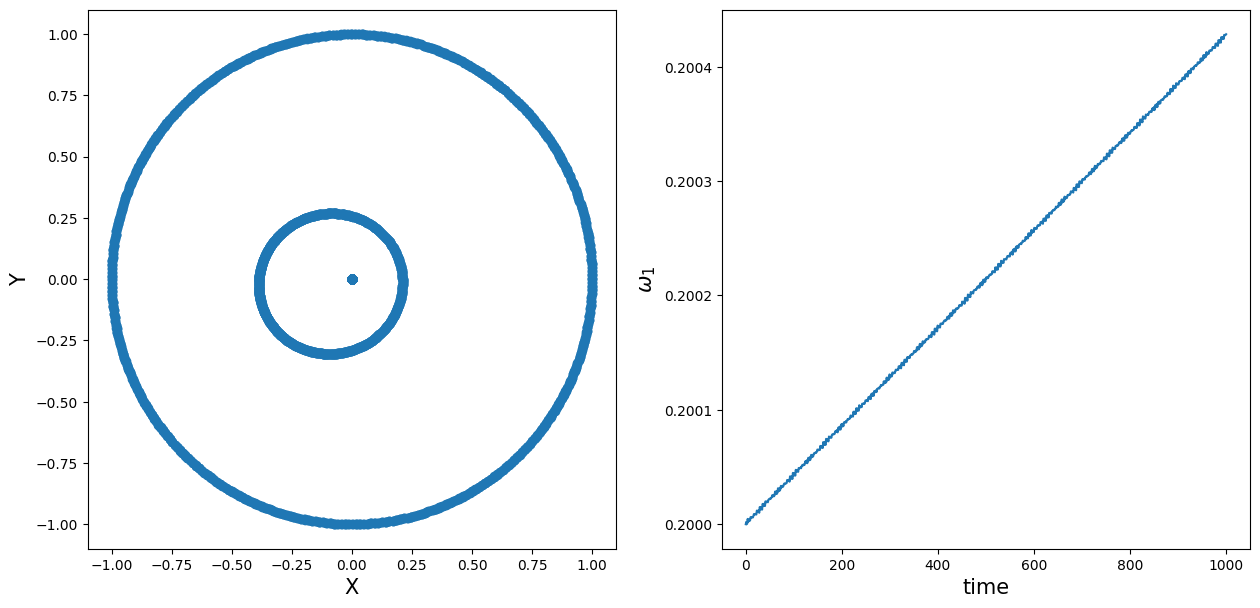

In [16]:
fig,ax = plt.subplots(figsize=(15,7),ncols=2)

ax[0].scatter(x_par.T,y_par.T)
ax[1].plot(times,omegas_par)

ax[0].set_xlabel("X",fontsize=15)
ax[0].set_ylabel("Y",fontsize=15)
ax[1].set_xlabel("time",fontsize=15)
ax[1].set_ylabel("$\omega_1$",fontsize=15)
plt.show()

## Case 2: Now we integrate the same system, but swap that second body with a ring (now there are only 2 bodies) !

In [17]:
def ringforce(reb_sim, rebx_force, particles, N):  #reboundx x force function definition
    #Define ring parameters here Ring Mass and Radius
    #Assumes: ring lies in the x-y plane. 
    G = sim.G
    M = 3e-6
    a = 1
    for i in range(1,N): #loop over the particles (but skip the primary at 0, it's centered on the ring and expereiences 0 net force)
        x,y,z = np.array(sim.particles[i].xyz) - np.array(sim.particles[0].xyz)  # these are the xyz coordinates for each particle relative to the star (the ring is around the star)
        r = np.sqrt(x**2 + y**2) # this is the radius in the x-y plane
        theta = np.arctan2(y,x) #this is the angle theta in that plane
        
        R = np.sqrt(r**2 + z**2) # this is the radius in full 3d
        d = np.sqrt(a**2 - 2*a*r + R**2) #other intermediate parameters
        p = np.sqrt(a**2 + 2*a*r + R**2)
        q2 = a**2 - 2*r**2 + R**2 
        k = -(4*a*r)/(a**2 - 2*a*r + R**2)
        
        atheta = 0 #it's symmetric! no force in theta
        ar = ((G*M)/(np.pi*r*d)) * ( (q2/p**2)* ellipe(k) - ellipk(k)) #use elliptic functions from scipy
        az = - ((G*M)/(np.pi*p**2)) * (z/d) * ellipe(k)
                
        particles[i].ax +=  ar*np.cos(theta) - atheta*np.sin(theta) #this converts cylindrical accels to cartesian
        particles[i].ay +=  ar*np.sin(theta) + atheta*np.cos(theta)
        particles[i].az +=  az       

In [18]:
sim = rebound.Simulation() #setup simulataion
sim.integrator = 'ias15'  #choose integrator

sim.add(m=1,x=1e-3,y=0,z=0)
sim.add(m=0,a=0.3,e=0.3,omega=0.2)
sim.move_to_com()

rebx = reboundx.Extras(sim) #attach to force
myforce = rebx.create_force("ringforce")  #name the force
myforce.force_type = "vel" #set force type to vel 
myforce.update_accelerations = ringforce  #update acclerations using the function!
rebx.add_force(myforce)


In [19]:
Nsim = sim.N
x_ring = np.zeros((Nsim,Nout)) #all empty arrys (all zeros) length of Nout (height Nsim)
y_ring = np.zeros((Nsim,Nout))
z_ring = np.zeros((Nsim,Nout))
omegas_ring = np.zeros(Nout)


for i, time in enumerate(times):
    sim.integrate(time)
    for j in range(len(sim.particles)):
        x_ring[j,i] = sim.particles[j].x
        y_ring[j,i] = sim.particles[j].y
        z_ring[j,i] = sim.particles[j].z
    omegas_ring[i] = sim.particles[1].omega

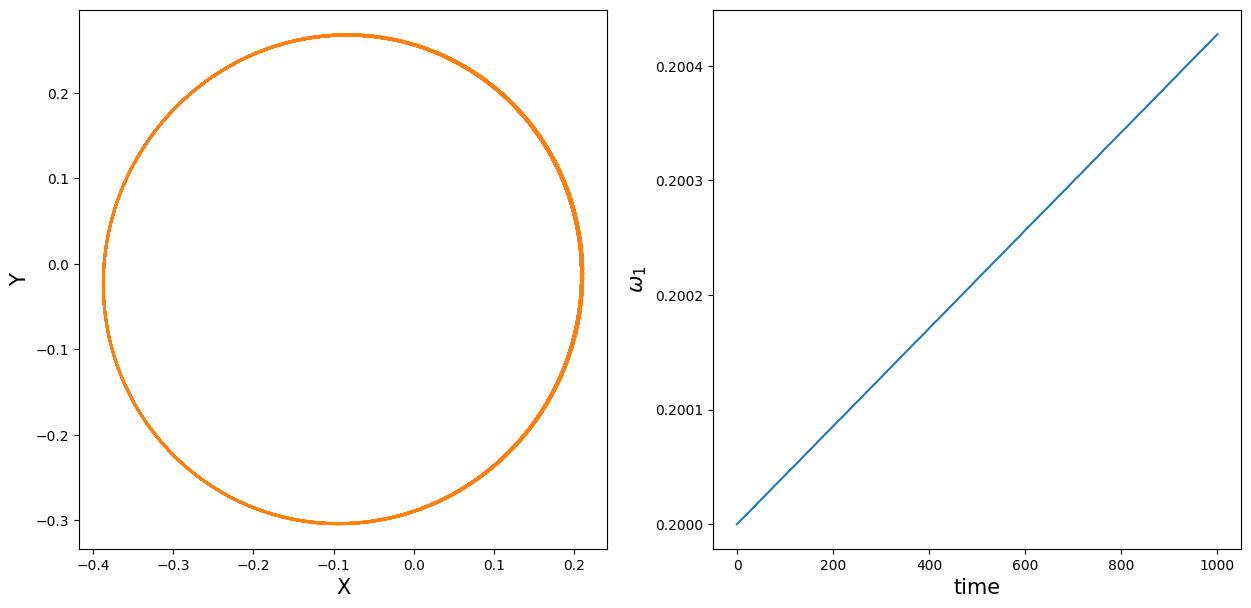

In [20]:
fig,ax = plt.subplots(figsize=(15,7),ncols=2)

ax[0].plot(x_ring.T,y_ring.T)
ax[1].plot(times,omegas_ring)

ax[0].set_xlabel("X",fontsize=15)
ax[0].set_ylabel("Y",fontsize=15)
ax[1].set_xlabel("time",fontsize=15)
ax[1].set_ylabel("$\omega_1$",fontsize=15)
plt.show()

## Let's check if the two precession rates line up? 


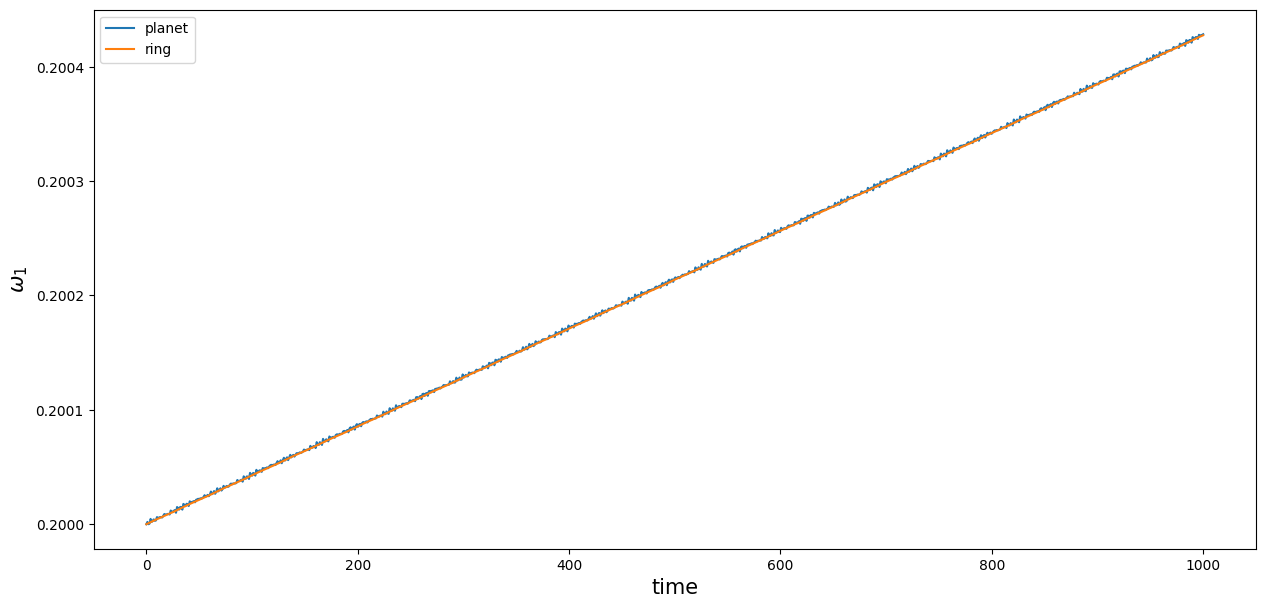

In [21]:
fig,ax = plt.subplots(figsize=(15,7))
plt.plot(times, omegas_par, label='planet')
plt.plot(times, omegas_ring, label='ring')
plt.legend()
plt.xlabel("time",fontsize=15)
plt.ylabel("$\omega_{1}$",fontsize=15)
plt.show()

## Looks pretty good to me!